In [ ]:
# Install TA dependency
!pip install pandas-ta

import pandas_ta as ta

## Test

In [ ]:
!git clone https://github.com/Pfannen/AI-Stock-Agent.git

%cd AI-Stock-Agent/stock_agent_reusables
!pip install -r requirements.txt
%cd ..

In [ ]:
!unzip stock_agent_reusables.zip

%cd stock_agent_reusables
!pip install -r requirements.txt
%cd ..

In [3]:
import stock_agent_reusables
from stock_agent_reusables.classes.StockData import StockData
from stock_agent_reusables.classes.RLModelBuilder import ModelBuilder
from stock_agent_reusables.utils import lookback_data_transform, get_data_loaders, plot_model_predictions, train
from stock_agent_reusables.classes.NonRLModels import LinearModel, LSTMModel

In [4]:
AMZNStockData = StockData(ticker="AMZN",
                          start_date="12/12/2015",
                          end_date="11/12/2023",
                          interval="1d")

In [5]:
AMZNStockData.stock_df.head()
new_df = AMZNStockData.add_indicators_to_data(indicators=[
    lambda df: (ta.sma(close=df['close'], length=12), "12_SMA"),
    lambda df: (ta.sma(close=df['close'], length=50), "50_SMA"),
    lambda df: (ta.obv(close=df['close'], volume=df['volume']), 'OBV'),
    lambda df: (ta.rsi(close=df['close'], length=12), "RSI")
])
new_df.head()

new_df = AMZNStockData.scale_data(data=new_df, columns_to_scale=["open", "high", "low", "close", "adjclose", "12_SMA", "50_SMA"], inverse=False)
new_df.head()

,open,high,low,close,adjclose,volume,12_SMA,50_SMA,OBV,RSI
2016-02-25,0.001082,0.002299,-0.002136,0.000966,0.000966,90510000,-0.007989,0.012809,-329928000.0,52.467728
2016-02-26,0.002529,0.003277,0.000343,0.000991,0.000991,97540000,-0.006071,0.012163,-232388000.0,52.497244
2016-02-29,0.000604,0.004004,0.000135,0.000138,0.000138,82908000,-0.004445,0.011496,-315296000.0,51.319528
2016-03-01,0.001324,0.008546,0.001233,0.008480,0.008480,100770000,-0.002473,0.010887,-214526000.0,60.725569
2016-03-02,0.009332,0.010354,0.006800,0.008848,0.008848,91644000,-0.000556,0.010318,-122882000.0,61.087433


In [9]:
AMZNModel = ModelBuilder(df=new_df,
                         window_size=12,
                         train_percentage=0.8,
                         eval_callback_freq=100000,
                         model_save_path="/content/Models/AMZN")

Using cuda device


In [ ]:
AMZNModel.train_model(timesteps=1000000)

info {'total_reward': 0.0945138059114018, 'total_profit': 1.0750789848194513, 'position': <Positions.Short: 0>}


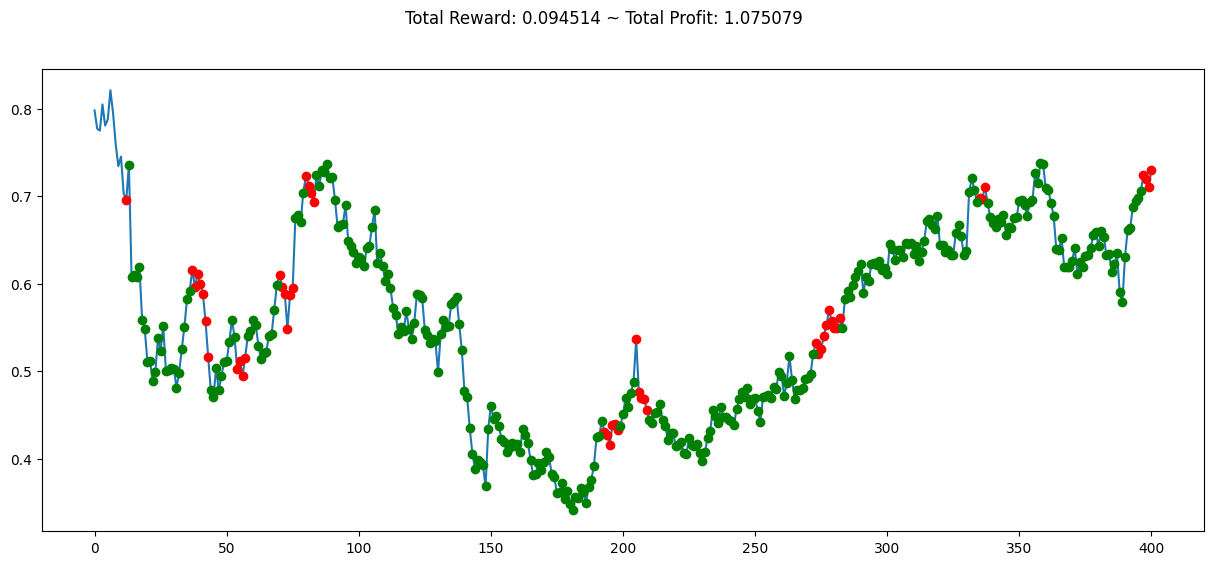

In [28]:
AMZNModel.test_model()

In [38]:
test_lin_data = new_df.drop(columns=['adjclose', 'OBV', 'volume', 'RSI', 'open', 'high', 'low'])
lookback_interval = 7
test_lin_data = lookback_data_transform(data=test_lin_data, lookback_interval=lookback_interval)
test_lin_labels = AMZNStockData.get_classification_labels(hold_threshold_percentage=0)
len_diff = len(test_lin_labels) - len(test_lin_data)
test_lin_labels = test_lin_labels[len_diff:]
test_lin_train_dl, test_lin_test_dl = get_data_loaders(data=test_lin_data, labels=test_lin_labels)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
import torch

torch.manual_seed(42)
TestLinModel = LinearModel(in_features=len(test_lin_data[0]), hidden_units=10, out_features=2)
lin_optimizer = torch.optim.SGD(params=TestLinModel.parameters(), lr=0.1)
lin_loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
res = train(model=TestLinModel,
            train_dataloader=test_lin_train_dl,
            test_dataloader=test_lin_test_dl,
            optimizer=lin_optimizer,
            loss_fn=lin_loss_fn,
            epochs=1000,
            device="cpu")

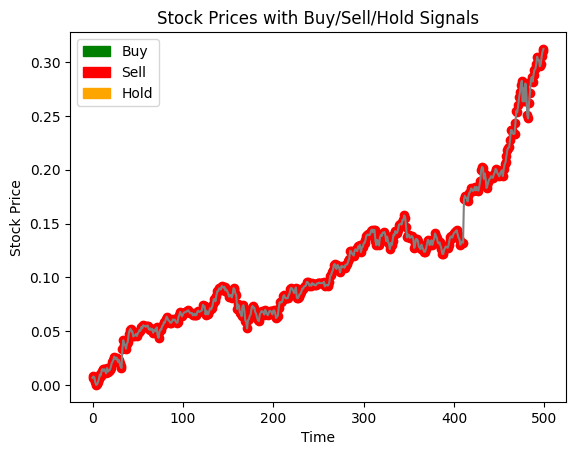

In [41]:
with torch.inference_mode():
  model_preds = torch.argmax(TestLinModel(torch.tensor(test_lin_data[:500], dtype=torch.float32)), dim=1)
  plot_model_predictions(stock_prices=list(new_df[12:512]['close']), signals=model_preds.numpy())

## LSTM Test

In [42]:
test_lstm_data = new_df.drop(columns=['adjclose', 'OBV', 'volume', 'RSI'])
lookback_interval = 7
test_lstm_data = lookback_data_transform(data=test_lstm_data, lookback_interval=lookback_interval, lstm_transform=True)
test_lstm_labels = AMZNStockData.get_classification_labels(hold_threshold_percentage=0)
len_diff = len(test_lstm_labels) - len(test_lstm_data)
test_lstm_labels = test_lstm_labels[len_diff:]
test_lstm_train_dl, test_lstm_test_dl = get_data_loaders(data=test_lstm_data, labels=test_lstm_labels)

In [33]:
import torch

torch.manual_seed(42)
TestLSTMModel = LSTMModel(in_features=len(test_lstm_data[0][0]),
                          hidden_units=len(test_lstm_data[0]),
                          out_features=2,
                          stacked_layer_count=3,
                          device="cpu")
lstm_optimizer = torch.optim.SGD(params=TestLSTMModel.parameters(), lr=0.1)
lstm_loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
res = train(model=TestLSTMModel,
            train_dataloader=test_lstm_train_dl,
            test_dataloader=test_lstm_test_dl,
            optimizer=lstm_optimizer,
            loss_fn=lstm_loss_fn,
            epochs=1000,
            device="cpu")

<ipython-input-35-eb71e6377ef4>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  model_preds = torch.argmax(TestLSTMModel(torch.tensor(test_lstm_data[:600], dtype=torch.float32)), dim=1)


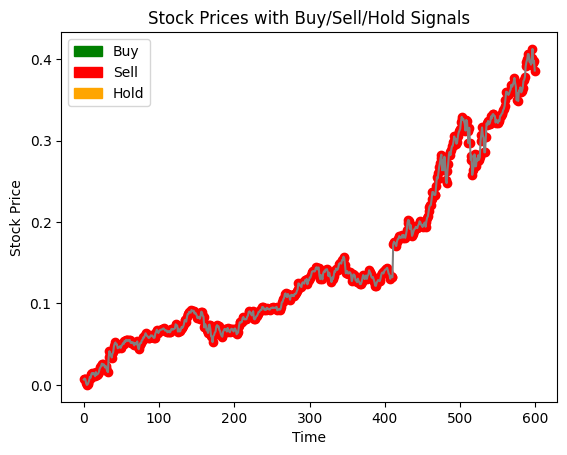

In [35]:
with torch.inference_mode():
  model_preds = torch.argmax(TestLSTMModel(torch.tensor(test_lstm_data[:600], dtype=torch.float32)), dim=1)
  plot_model_predictions(stock_prices=list(new_df[12:612]['close']), signals=model_preds.numpy())